## Data functions

In [193]:
#Read in trajectory file
import numpy as np
import matplotlib.pyplot as plt
import json

servoIndices = {
    "NeckTilt": 0,
    "NeckPan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def read_traj_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_traj(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_traj(traj['Current']) for traj in data['Trajectories']}
    gyro = {traj['UniqueID']: parse_traj(traj['Gyro']) for traj in data['Trajectories']}
    accel = {traj['UniqueID']: parse_traj(traj['Accel']) for traj in data['Trajectories']}
    angles = {traj['UniqueID']: parse_traj(traj['Angles']) for traj in data['Trajectories']}
    return trajectories, currents, gyro, accel, angles

def parse_traj(traj):
    return np.abs(np.array(traj))



## read in metrics from CurrentPositionMapping.json as dictionary
def mapping_metrics_to_dic(file_path):
    # Read the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Create a dictionary to store the results
    result = {}
    
    # Iterate through each mapping in the JSON data
    for mapping in data['Mapping']:
        # Extract the UniqueID (assuming it's always a list with one element)
        unique_id = mapping['UniqueID'][0]
        
        # Create a dictionary for this mapping, excluding the UniqueID
        mapping_dict = {key: value for key, value in mapping.items() if key != 'UniqueID'}
        
        # Add this mapping to the result dictionary, using the UniqueID as the key
        result[unique_id] = mapping_dict
    
    return result


#normalise the data
def normalise_data(data, servos):
    normalised_data = {}
    for key in data.keys():
        for servo in servos:
            max_value = data[key][:, servoIndices[servo]].max()
            if max_value == 0:
                print(f"Warning: Maximum value for {key} is zero, skipping normalization.")
                normalised_data[key] = data[key]  # Or handle as needed
            else:
                normalised_data[key] = data[key] / max_value

    return normalised_data



## Plot functions

In [194]:
def plot_one_servo_traj(dict, metrics, servo, datatype="Position", plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} {datatype} Trajectories')
    
    for i, traj_id in enumerate(traj_ids):
        data = dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]])
        if (datatype == "Position"):
            axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
            axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.tight_layout()
    plt.show()

#plot both current and position trajectories with twin y axis
def plot_one_servo_traj_with_current(pos_dict, current_dict, metrics, servo, plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(pos_dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} Position and Current Trajectories')
    #some distance between the title and the plots
    fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)
    
    for i, traj_id in enumerate(traj_ids):
        data = pos_dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]], label='Position')
        axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
        axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        if i % plots_per_row == 0:
            axs[i].set_ylabel('Position')
        axs[i].set_xlabel('Time')
        axs[i].tick_params(axis='y', colors='b')
        
        current_data = current_dict[traj_id]
        # Create a twin y-axis for the current data
        axs2 = axs[i].twinx()
        axs2.plot(current_data[:, servoIndices[servo]], 'r', label='Current')
        if (i + 1) % plots_per_row == 0:
            axs2.set_ylabel('Current')
        axs2.tick_params(axis='y', colors='r')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.show()

def plot_one_trajectory(trajectories, metrics, traj_id, servo):
    traj = trajectories[traj_id]
    plt.plot(traj[:, servoIndices[servo]])
    plt.plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'ro', label='Starting Position')
    plt.plot(len(traj), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
    plt.title(f'Trajectory: {traj_id}')
    plt.legend()
    plt.show()

def filter_by_overshot(dict, traj_id, servo):
    return dict[traj_id]['OvershotGoal'][servoIndices[servo]] == 1

def filter_by_start_position(dict, traj_id, servo, start):
    return abs(dict[traj_id]['StartingPosition'][servoIndices[servo]]-start) <= 10



In [195]:
import matplotlib.pyplot as plt

def plot_3D_data(data, unique_ids):
    if not isinstance(unique_ids, list):
        unique_ids = [unique_ids]
    
    n_plots = len(unique_ids)
    n_row = (n_plots + 3) // 4  # Calculate the number of rows needed
    
    fig = plt.figure(figsize=(16, n_row * 4))
    
    for i, unique_id in enumerate(unique_ids):
        ax = fig.add_subplot(n_row, 4, i + 1, projection='3d')

        # Add some space between the plots and the z axis
        ax.view_init(elev=20., azim=30)
        
        # Extract data for the specific unique ID
        data_filtered = [item for item in data[unique_id] if len(item) == 3]
        
        # Extract x, y, z components from the filtered arrays
        x, y, z = zip(*data_filtered)
        
        # Plot data as a path
        ax.plot(x, y, z, c='blue', label=f'Path for id: {unique_id}')
        ax.scatter(x[0], y[0], z[0], c='red', label='Start')
        ax.scatter(x[-1], y[-1], z[-1], c='green', label='End')
        
        # Set labels and title based on data type
        if data is gyro:
            ax.set_title(f'3D Gyro Plot for ID: {unique_id}')
            ax.set_xlabel('Gyro X Axis')
            ax.set_ylabel('Gyro Y Axis')
            ax.set_zlabel('Gyro Z Axis')
        elif data is accel:
            ax.set_title(f'3D Accel Plot for ID: {unique_id}')
            ax.set_xlabel('Accel X Axis')
            ax.set_ylabel('Accel Y Axis')
            ax.set_zlabel('Accel Z Axis')
        else:
            ax.set_title(f'3D Plot for ID: {unique_id}')
            ax.set_xlabel('X Axis')
            ax.set_ylabel('Y Axis')
            ax.set_zlabel('Z Axis')
        
        # Reduce the number of ticks to avoid clutter
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.zaxis.set_major_locator(plt.MaxNLocator(5))
    
    # Create a single legend for all subplots
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    
    plt.show()



## Reading data

In [196]:
# Read in trajectory json file
all_trajectories, all_currents, all_gyro, all_accel, all_angles = read_traj_json('TrajectoriesTorso.json')
mapping_metrics = mapping_metrics_to_dic('CurrentPositionMappingTorso.json')
num_trajectories_to_plot = 15
servos_in_use = ['NeckTilt', 'NeckPan']

##Take the last trajectories and make a dictionary of them
trajectories = {key: all_trajectories[key] for key in list(all_trajectories.keys())[-num_trajectories_to_plot:]}
currents = {key: all_currents[key] for key in list(all_currents.keys())[-num_trajectories_to_plot:]}
gyro = {key: all_gyro[key] for key in list(all_gyro.keys())[-num_trajectories_to_plot:]}
accel = {key: all_accel[key] for key in list(all_accel.keys())[-num_trajectories_to_plot:]}
angles = {key: all_angles[key] for key in list(all_angles.keys())[-num_trajectories_to_plot:]}

# Starting and goal position distributions

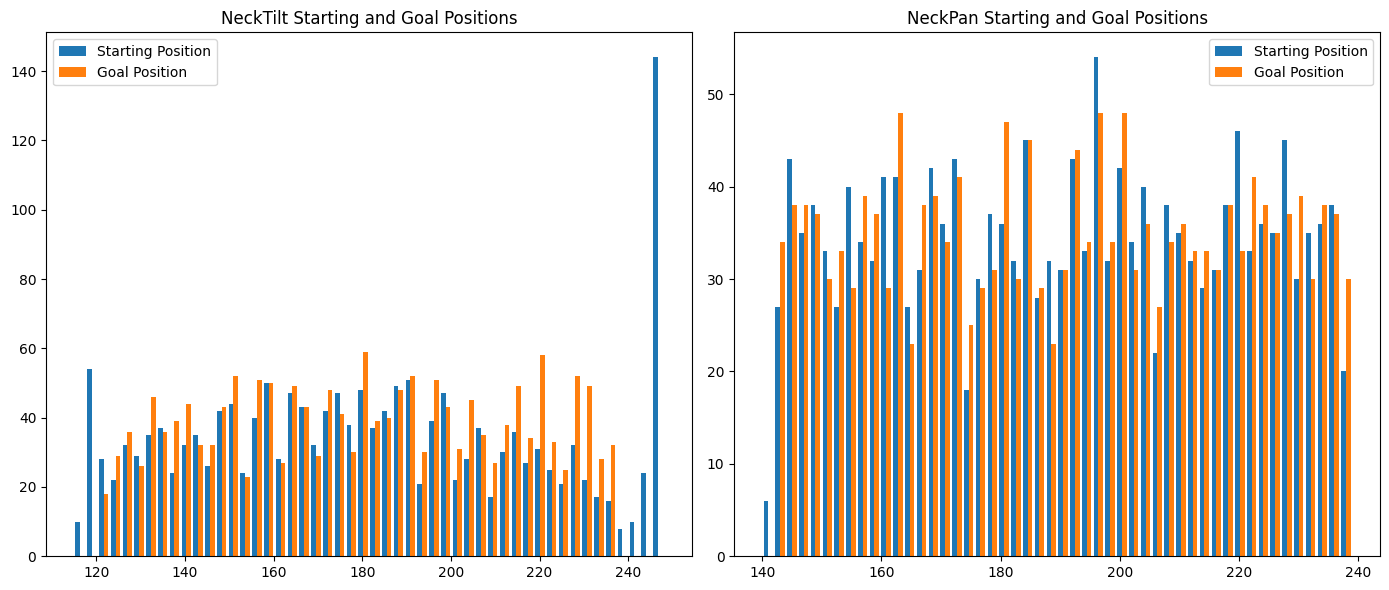

In [197]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for NeckTilt
starting_positions_tilt = [mapping_metrics[key]['StartingPosition'][servoIndices['NeckTilt']] for key in mapping_metrics]
goal_positions_tilt = [mapping_metrics[key]['GoalPosition'][servoIndices['NeckTilt']] for key in mapping_metrics]
axs[0].hist([starting_positions_tilt, goal_positions_tilt], bins=50, label=['Starting Position', 'Goal Position'])
axs[0].set_title('NeckTilt Starting and Goal Positions')
axs[0].legend()

# Plot for NeckPan
starting_positions_pan = [mapping_metrics[key]['StartingPosition'][servoIndices['NeckPan']] for key in mapping_metrics]
goal_positions_pan = [mapping_metrics[key]['GoalPosition'][servoIndices['NeckPan']] for key in mapping_metrics]
axs[1].hist([starting_positions_pan, goal_positions_pan], bins=50, label=['Starting Position', 'Goal Position'])
axs[1].set_title('NeckPan Starting and Goal Positions')
axs[1].legend()

plt.tight_layout()
plt.show()

In [198]:
def calculate_average_min_current(servo, servoIndices, mapping_metrics, ids):
    start_position_averages = {}

    for id in ids:
        # Get the start position and MinCurrentToMoveFromStart for the specified servo
        start_pos = mapping_metrics[id]['StartingPosition'][servoIndices[servo]]
        min_current = mapping_metrics[id]['MinCurrentToMoveFromStart'][servoIndices[servo]]

        # Group values by start position
        if start_pos not in start_position_averages:
            start_position_averages[start_pos] = []
        
        start_position_averages[start_pos].append(min_current)
    
    # Calculate average MinCurrentToMoveFromStart for each start position
    for start_pos in start_position_averages:
        start_position_averages[start_pos] = np.mean(start_position_averages[start_pos])

    return start_position_averages


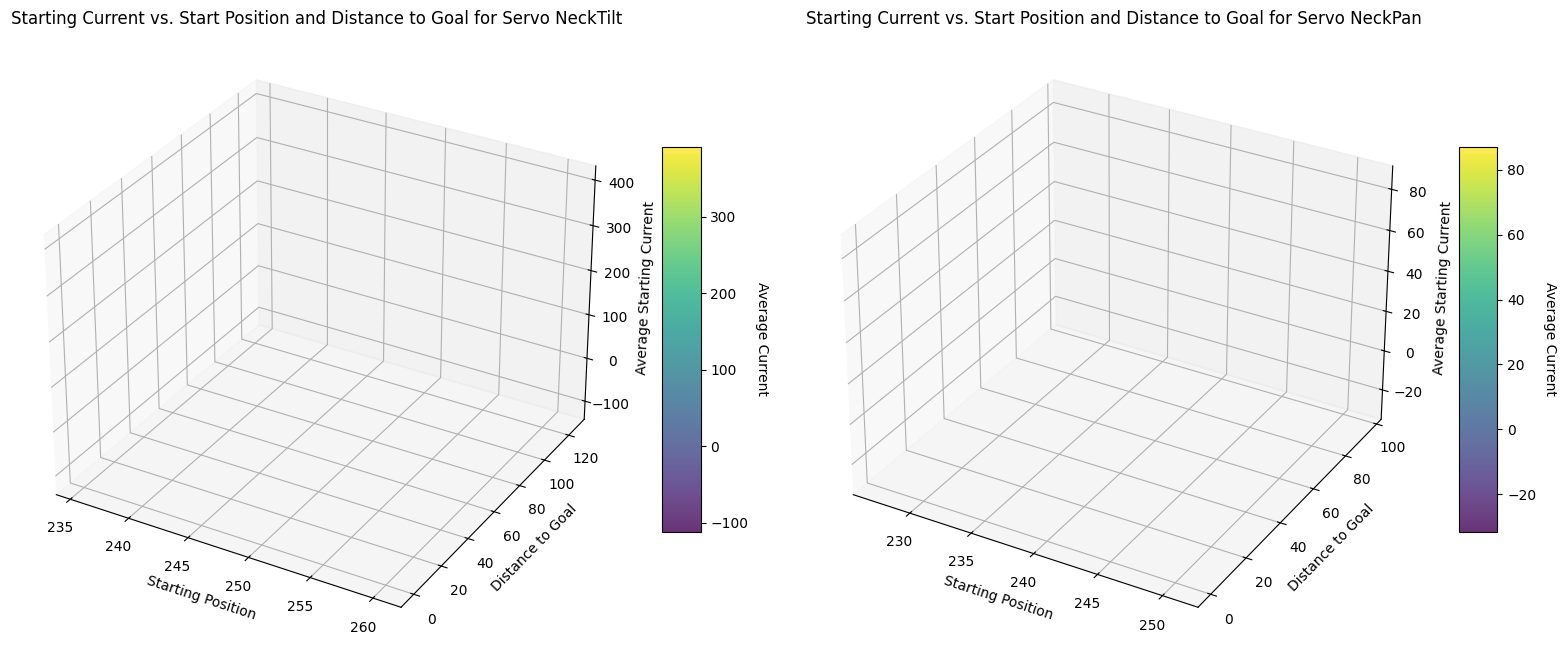

In [205]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_start_current_vs_distance(data, servos, servo_indices, ids):
    fig, axs = plt.subplots(1, len(servos), figsize=(16, 8), subplot_kw={'projection': '3d'})

    for i, servo in enumerate(servos):
        start_positions = []
        distances_to_goal = []
        starting_currents = []

        for id in ids:
            # Retrieve starting and goal positions
            start_pos = data[id]["StartingPosition"][servo_indices[servo]]
            goal_pos = data[id]["GoalPosition"][servo_indices[servo]]
            
            # Calculate distance to goal
            distance_to_goal = abs(goal_pos - start_pos)
            
            # Retrieve MinCurrentToMoveFromStart
            min_current = data[id]["MinCurrentToMoveFromStart"][servo_indices[servo]]
            
            # Store values
            start_positions.append(start_pos)
            distances_to_goal.append(distance_to_goal)
            starting_currents.append(min_current)
        
        # Create a grid for smooth surface plotting
        xi = np.linspace(min(start_positions), max(start_positions), 100)
        yi = np.linspace(min(distances_to_goal), max(distances_to_goal), 100)
        xi, yi = np.meshgrid(xi, yi)
        zi = griddata((start_positions, distances_to_goal), starting_currents, (xi, yi), method='cubic')

        # Plotting
        ax = axs[i]
        surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none', alpha=0.8)
        # Add shading for depth effect
        surf._facecolors2d = surf._facecolor3d
        surf._edgecolors2d = surf._edgecolor3d

        # Add color bar
        color_bar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
        color_bar.set_label('Average Current', rotation=270, labelpad=15)
        
        # Labels and title
        ax.set_xlabel('Starting Position')
        ax.set_ylabel('Distance to Goal')
        ax.set_zlabel('Average Starting Current')
        ax.set_title(f'Starting Current vs. Start Position and Distance to Goal for Servo {servo}')
        
     
    
    plt.tight_layout()
    plt.show()

# Usage example
# Servo indices: 0 for tilting servo, 1 for pan servo
plot_start_current_vs_distance(mapping_metrics, ['NeckTilt', 'NeckPan'], servoIndices, all_currents.keys())


In [200]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

def plot_average_current(data, servos, mapping_metrics):
    fig = plt.figure(figsize=(16, 8))
    
    for i, servo in enumerate(servos):
        x = []
        y = []
        z = []

        # Collect data points for starting position and distance to goal
        for key in data.keys():
            start_pos = mapping_metrics[key]['StartingPosition'][servoIndices[servo]]
            goal_pos = mapping_metrics[key]['GoalPosition'][servoIndices[servo]]
            
            # Calculate distance to the goal
            distance_to_goal = abs(goal_pos - start_pos)
            
            # Average current over the data points for this start and distance
            current_values = data[key][:, servoIndices[servo]]
            avg_current = np.mean(current_values)
            
            x.append(start_pos)
            y.append(distance_to_goal)
            z.append(avg_current)

        # Create a grid for the surface plot
        xi, yi = np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100)
        xi, yi = np.meshgrid(xi, yi)
        zi = griddata((x, y), z, (xi, yi), method='cubic')

        # Create a 3D subplot for each servo
        ax = fig.add_subplot(1, len(servos), i + 1, projection='3d')
        surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
        
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

        ax.set_xlabel('Starting Position')
        ax.set_ylabel('Distance to Goal Position')
        ax.set_zlabel('Average Current')
        ax.set_title(f'Topographical Map of Average Current for {servo}')

    plt.tight_layout()
    plt.show()


In [201]:
plot_average_current(all_currents, ['NeckTilt', 'NeckPan'])

TypeError: plot_average_current() missing 1 required positional argument: 'mapping_metrics'

## Normalised data

In [181]:
normlised_currents = normalise_data(all_currents, servos_in_use)
normlised_trajectories = normalise_data(all_trajectories, servos_in_use)
normlised_gyro = normalise_data(all_gyro, servos_in_use)
normlised_accel = normalise_data(all_accel, servos_in_use)
normlised_angles = normalise_data(all_angles, servos_in_use)

In [192]:
normalised_currents.keys()

dict_keys([699873, 699874, 699875, 699876, 699877, 77909, 77910, 77911, 77912, 77913, 77914, 77915, 77916, 77917, 77918, 77919, 77920, 77921, 77922, 77923, 77924, 77925, 77926, 77927, 77928, 77929, 778202, 778203, 778204, 778205, 778206, 778207, 778208, 778209, 778210, 778211, 778212, 778213, 778214, 778215, 778216, 778217, 778218, 778219, 778220, 778221, 778222, 778223, 778224, 778225, 778226, 778227, 778228, 778229, 778230, 778231, 778232, 778233, 778234, 778235, 778236, 778237, 778238, 778239, 778240, 778241, 778242, 778243, 778244, 778245, 778246, 778247, 778248, 778249, 778250, 778251, 778252, 778253, 778254, 778255, 778256, 778257, 778258, 778259, 778260, 778261, 778262, 778263, 778264, 778265, 778266, 778267, 778268, 778269, 778270, 778271, 778272, 778273, 778274, 778275, 778276, 778277, 778278, 778279, 778280, 778281, 778282, 778283, 778284, 778285, 778286, 778287, 778288, 778289, 778290, 778291, 778292, 778293, 778294, 778295, 778296, 778297, 778298, 778299, 778300, 778301, 77

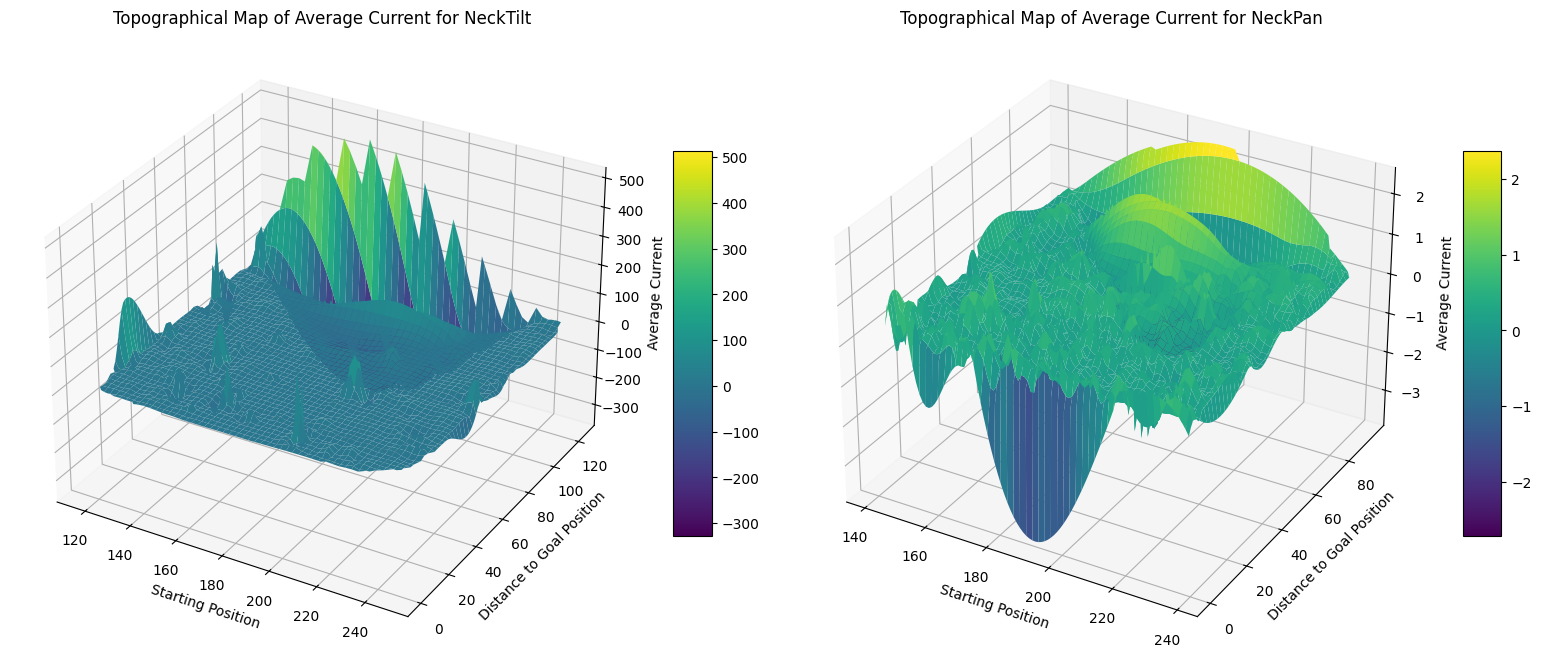

In [182]:
plot_average_current(normlised_currents, ['NeckTilt', 'NeckPan'])